In [2]:
import gc
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.utils.data import Dataset
import librosa, librosa.display
import soundfile

from tqdm.notebook import tqdm

from vq_vae_2_half_tmb import Model
from pixel_snail import PixelSNAIL

In [3]:
import os

# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_LAUNCH_BLOCKING"] = "0"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [4]:
seed = 1
channel = 512
n_res_block = 4
n_res_channel = 256
n_out_res_block = 0
n_cond_res_block = 3
dropout = 0.1
temp = 1.0
batch=4

In [5]:
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
#device = torch.device('cpu')

In [7]:
SAVE_PATH = "./save_models"

In [8]:
num_hiddens = 128 #128
num_residual_hiddens = 32
num_residual_layers = 4
embedding_dim = 64 #64 : 코드북에서 한 ebedding의 크기
num_embeddings = 256 #512 : embbeding vector 개수 -> indices의 최대 크기
commitment_cost = 0.25

In [9]:
model = Model(num_hiddens=num_hiddens, 
                  num_residual_layers=num_residual_layers,
                  num_residual_hiddens=num_residual_hiddens,
                  num_embeddings=num_embeddings,
                  embedding_dim=embedding_dim, 
                  commitment_cost=commitment_cost).to(device)

score = 0.008422496728599072
MODEL_PATH = f'{SAVE_PATH}/vqvae2_tmb-{score:.5f}_dict.pt'
model.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

In [10]:
torch.cuda.empty_cache()

In [11]:
# Sampling with PixelSNAIL
@torch.no_grad()
def sample_model(model, batch, size, temperature, condition=None):
    #row = torch.ones(batch, *size, dtype=torch.int64).to(device)
    row = torch.zeros(batch, *size, dtype=torch.int64).to(device)
    cache = {}
    for i in tqdm(range(size[0])):
        for j in range(size[1]):
            out, cache = model(row[:, : i + 1, :], condition=condition, cache=cache)
            prob = torch.softmax(out[:, :, i, j] / temperature, 1)
            sample = torch.multinomial(prob, 1).squeeze(-1)
            row[:, i, j] = sample
        torch.cuda.empty_cache()

    return row

In [12]:
def scaled(x):
    return (x + 80.0) / (3.8147e-06 + 80)
def unscaled(x):
    return x * (3.8147e-06 + 80) - 80.0

In [13]:
batch = 4
channel = 512
n_res_block = 4
n_res_channel = 256
n_out_res_block = 0
n_cond_res_block = 3
dropout = 0.1

In [14]:
import importlib
import pixel_snail
importlib.reload(pixel_snail)
from pixel_snail import PixelSNAIL

In [15]:
channel = 256
n_res_block = 4
n_res_channel = 256
n_out_res_block = 0
n_cond_res_block = 3
dropout = 0.1
temp = 1.0

model_top = PixelSNAIL(
    [10, 16], # [32, 40],
    512,
    channel,
    5,
    4,
    n_res_block,
    n_res_channel,
    dropout=dropout,
    n_out_res_block=n_out_res_block,
)

model_middle = PixelSNAIL(
    [20, 32], # [20, 256]
    512,
    channel,
    5,
    4,
    n_res_block,
    n_res_channel,
    dropout=dropout,
    n_cond_res_block=n_cond_res_block,
    cond_res_channel=n_res_channel,
)

model_bottom = PixelSNAIL(
    [40, 64], # [20, 256]
    512,
    channel,
    5,
    4,
    n_res_block,
    n_res_channel,
    attention=False,
    dropout=dropout,
    n_cond_res_block=n_cond_res_block,
    cond_res_channel=n_res_channel,
)

In [16]:
model_top = model_top.to(device)
model_middle = model_middle.to(device)
model_bottom = model_bottom.to(device)

In [17]:
model_top.load_state_dict(torch.load(f"{SAVE_PATH}/pixelsnail_ckp/pixelsnail_top_tmb.pt"))
model_middle.load_state_dict(torch.load(f"{SAVE_PATH}/pixelsnail_ckp/pixelsnail_mid_tmb.pt"))
model_bottom.load_state_dict(torch.load(f"{SAVE_PATH}/pixelsnail_ckp/pixelsnail_bot_tmb.pt"))

<All keys matched successfully>

In [18]:
top_sample = sample_model(model_top, batch, [10, 16], temp)
middle_sample = sample_model(model_middle, batch, [20, 32], temp, condition=top_sample)
bottom_sample = sample_model(model_bottom, batch, [40, 64], temp, condition=middle_sample)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

In [20]:
with torch.no_grad():
    quant_t = model.vq_top.embed_code(top_sample)
    quant_t = quant_t.permute(0, 3, 1, 2).contiguous()
    quant_m = model.vq_mid.embed_code(middle_sample)
    quant_m = quant_m.permute(0, 3, 1, 2).contiguous()
    quant_b = model.vq_bot.embed_code(bottom_sample)
    quant_b = quant_b.permute(0, 3, 1, 2).contiguous()

    out = model.decode(quant_t, quant_m, quant_b).squeeze().detach().cpu().numpy()

In [21]:
out = unscaled(out).reshape(-1, 80, 512)

In [22]:
out.shape

(4, 80, 512)

  0%|          | 0/1 [00:00<?, ?it/s]

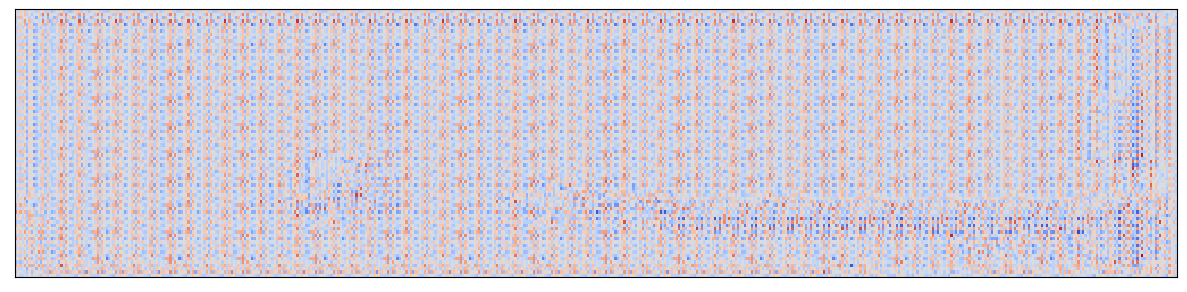

In [27]:
num = len(out)
fig = plt.figure(figsize=(15, 4 * num))
for i, o in enumerate(tqdm((out[3].reshape(-1, 80, 512)))):
    plt.subplot(num, 1, i + 1)
    librosa.display.specshow(o, sr=22050, hop_length=256)
    
    out_power = librosa.db_to_power(o, ref=80)
    y = librosa.feature.inverse.mel_to_audio(out_power, sr=22050, n_fft=2048, hop_length=256)
    soundfile.write(f"sample/sample_audio{i + 4}.wav", y, samplerate=22050, format='WAV')